

Method 1: Random Forest Regressor



In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import seaborn as sns
!pip install category_encoders  # Install category_encoders
from category_encoders import OneHotEncoder  # Import OneHotEncoder


In [2]:
df = pd.read_csv('/content/train_data.csv')

df.head()

,event_id,time_to_tca,mission_id,risk,max_risk_estimate,max_risk_scaling,miss_distance,relative_speed,relative_position_r,relative_position_t,...,t_sigma_rdot,c_sigma_rdot,t_sigma_tdot,c_sigma_tdot,t_sigma_ndot,c_sigma_ndot,F10,F3M,SSN,AP
0,0,1.566798,5,-10.204955,-7.834756,8.602101,14923.0,13792.0,453.8,5976.6,...,0.147350,58.272095,0.004092,0.165044,0.002987,0.386462,89.0,83.0,42.0,11.0
1,0,1.207494,5,-10.355758,-7.848937,8.956374,14544.0,13792.0,474.3,5821.2,...,0.059672,57.966413,0.003753,0.164383,0.002933,0.386393,89.0,83.0,42.0,11.0
2,0,0.952193,5,-10.345631,-7.847406,8.932195,14475.0,13792.0,474.6,5796.2,...,0.039258,57.907599,0.003576,0.164352,0.002967,0.386381,89.0,83.0,42.0,11.0
3,0,0.579669,5,-10.337809,-7.845880,8.913444,14579.0,13792.0,472.7,5838.9,...,0.022066,57.993905,0.003298,0.164309,0.002918,0.386400,89.0,83.0,40.0,14.0
4,0,0.257806,5,-10.391260,-7.852942,9.036838,14510.0,13792.0,478.7,5811.1,...,0.015075,57.946717,0.003670,0.164172,0.003220,0.386388,89.0,83.0,40.0,14.0


In [4]:
X = df.drop('risk', axis=1) # risk is the value we are interested in predicting
y = df['risk']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Identify categorical columns
categorical_cols = X_train.select_dtypes(include=['object']).columns

# Create a OneHotEncoder instance
encoder = OneHotEncoder(cols=categorical_cols, handle_unknown='ignore')

# Fit the encoder on the training data and transform both training and testing data
X_train_encoded = encoder.fit_transform(X_train)
X_test_encoded = encoder.transform(X_test)

# Replace infinite values with NaN
X_train_encoded = X_train_encoded.replace([np.inf, -np.inf], np.nan)

# Impute NaN values (if any) with the mean of the column
X_train_encoded = X_train_encoded.fillna(X_train_encoded.mean())

# Clip values to a reasonable range for float32
X_train_encoded = X_train_encoded.clip(np.finfo(np.float32).min, np.finfo(np.float32).max) # Clip values to prevent overflow

# Initialize and fit a RandomForestRegressor to get feature importances
clf = RandomForestRegressor(n_estimators=100, random_state=42)
clf.fit(X_train_encoded, y_train)  # Fit on the original training data

# Get feature importances
importance = clf.feature_importances_

# Set importance threshold
threshold = 0

# Select features based on importance
selected_features = [X.columns[i] for i, importance in enumerate(importance) if importance >= threshold]

# Create new datasets with selected features
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

# Now you can train your model with the selected features
clf_selected = RandomForestRegressor(n_estimators=100, random_state=42)
clf_selected.fit(X_train_selected, y_train)

# Make predictions and evaluate
y_pred = clf_selected.predict(X_test_selected)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error with selected features: {mse}")

In [ ]:
# Set importance threshold
threshold = 0

# Select features above the threshold
selected_features = [X.columns[i] for i, importance in enumerate(importance) if importance >= threshold]

selected_importance = [imp for i, imp in enumerate(importance) if X.columns[i] in selected_features]

# Create a new dataset with selected features
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

In [ ]:
# Train a new model using selected features
clf_selected = RandomForestRegressor(n_estimators=100, random_state=42)
clf_selected.fit(X_train_selected, y_train)

# Make predictions on the test set
y_pred = clf_selected.predict(X_test_selected)

# Evaluate the model (e.g., using accuracy)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error with selected features: {mse}")

In [ ]:
plt.bar(range(len(selected_features)), selected_importance)  # Use selected_importance here
plt.xticks(range(len(selected_features)), selected_features, rotation=90)
plt.title("Feature Importance in Random Forest")
plt.show()

Method 2: Recursive Feature Elimination (RFE)


In [5]:
categorical_cols = X_train.select_dtypes(include=['object']).columns

X_train_cleaned = X_train.dropna()
y_train_cleaned = y_train[X_train_cleaned.index]  # Make sure to align y_train

# Now you can fit the RFE model
model = LinearRegression()
total_features = X_train_cleaned.shape[1] # Use the cleaned data's shape
rfe = RFE(model, n_features_to_select=total_features)
rfe.fit(X_train_cleaned, y_train_cleaned) # Use the cleaned data for fitting

ValueError: could not convert string to float: 'DEBRIS'

In [ ]:
ranking = rfe.ranking_
num_irrelevant_features_eliminated = np.arange(total_features - 1, -1, -1)

In [ ]:
accuracy_list = []
for i in num_irrelevant_features_eliminated:
  X_train_cleaned = X_train.dropna()
  y_train_cleaned = y_train[X_train_cleaned.index]  # Make sure to align y_train
  rfe = RFE(model, n_features_to_select=(total_features - i))
  rfe.fit(X_train_cleaned, y_train_cleaned)
  X_test_cleaned = X_test.dropna()
  y_test_cleaned = y_test[X_test_cleaned.index]
  y_pred = rfe.predict(X_test_cleaned)
  mse = mean_squared_error(y_test_cleaned, y_pred) # Calculate Mean Squared Error
  accuracy_list.append(mse)  # Or append r2 if you prefer

plt.figure(figsize=(8, 6))
plt.plot(num_irrelevant_features_eliminated, accuracy_list, marker='o')
plt.xlabel("Number of Irrelevant Features Eliminated")
plt.ylabel("Accuracy")
plt.title("Model Performance as Irrelevant Features are Eliminated (RFE)")
plt.grid(True)
plt.show()

accuracy = accuracy_score(y_test, y_pred)
accuracy_list.append(accuracy)

plt.figure(figsize=(8, 6))
plt.plot(num_irrelevant_features_eliminated, accuracy_list, marker='o')
plt.xlabel("Number of Irrelevant Features Eliminated")
plt.ylabel("Accuracy")
plt.title("Model Performance as Irrelevant Features are Eliminated (RFE)")
plt.grid(True)
plt.show()

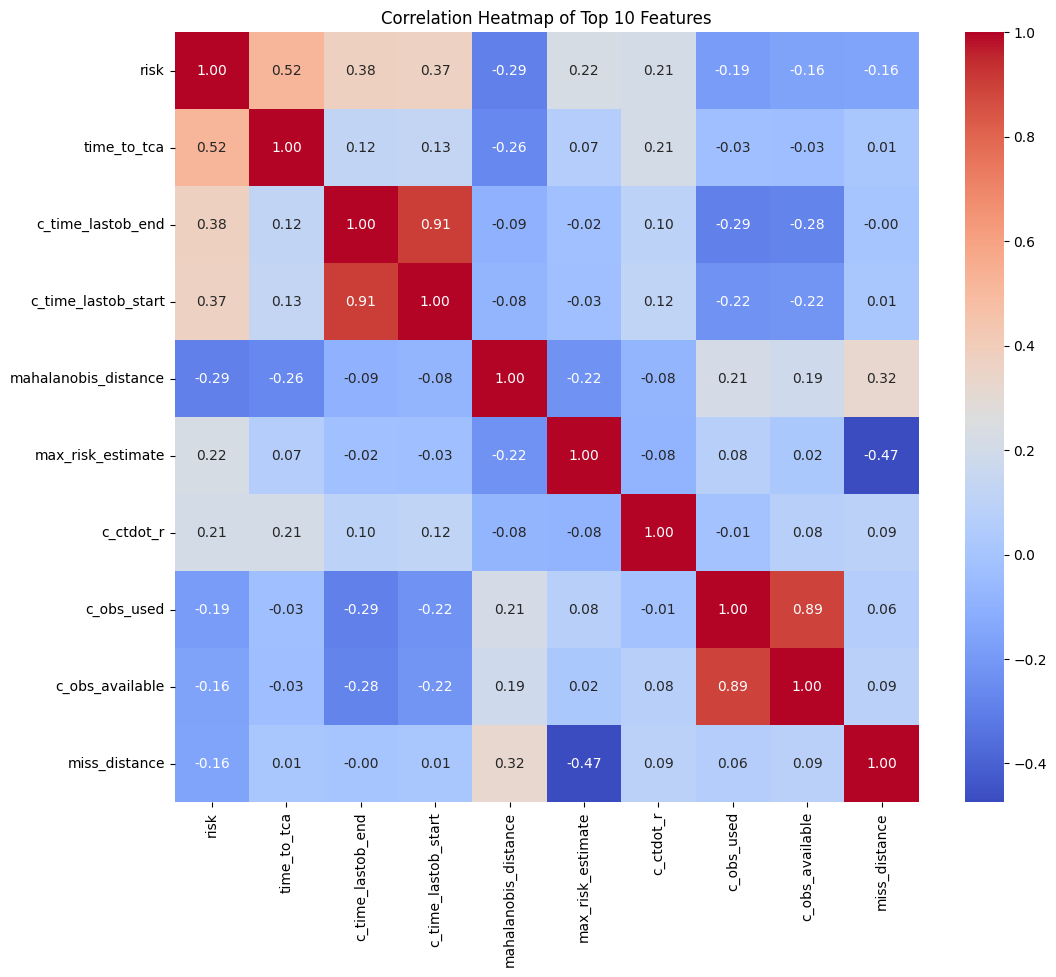

In [6]:
# Replace 'UNKNOWN' with NaN
df = df.replace('UNKNOWN', np.nan)

# Select only numerical features for correlation calculation
numerical_df = df.select_dtypes(include=['number'])

# Calculate the correlation matrix for numerical features with risk
corr_with_target = numerical_df.corrwith(df['risk'])

# Get the absolute values of correlations and sort them in descending order
top_10_features = corr_with_target.abs().sort_values(ascending=False).head(10).index

# Select the top 10 features from the original DataFrame
top_10_df = df[top_10_features]

# Calculate the correlation matrix for the top 10 features
corr_matrix = top_10_df.corr()

# Create the heatmap
plt.figure(figsize=(12, 10))  # Adjust figure size as needed
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap of Top 10 Features")
plt.show()